# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm`
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-0srtpd1q/granite-tsfm_15a8cfcbe1dc43318b93c74dc7fe9996
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-0srtpd1q/granite-tsfm_15a8cfcbe1dc43318b93c74dc7fe9996
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "/content/Macro_with_stocks.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('/content/Macro_with_stocks.csv')
df.head()

,Unnamed: 0,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,...,Volume_Change,DateOnly_x,Month,Date_y,Interest Rate (Federal Funds),Unemployment Rate,Consumer Price Index (CPI),GDP Growth (Real GDP % Change),Inflation (PCE Index),DateOnly_y
0,0,2015-01-02 00:00:00-05:00,37.843589,37.963058,37.099214,37.273823,1529200,0.1,0.0,A,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
1,2603,2015-01-02 00:00:00-05:00,51.430489,51.733690,50.284011,51.079914,10748600,0.0,0.0,AAL,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
2,5206,2015-01-02 00:00:00-05:00,24.778677,24.789800,23.879980,24.320431,212818400,0.0,0.0,AAPL,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
3,7809,2015-01-02 00:00:00-05:00,2.670000,2.670000,2.670000,2.670000,0,0.0,0.0,AMD,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
4,10412,2015-01-02 00:00:00-05:00,78.145002,78.736054,77.940102,78.546913,1462700,0.0,0.0,AMT,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01


In [6]:
df['Stock_encoded'], uniques = pd.factorize(df['Stock'])
unique_encoded_values = df['Stock_encoded'].unique().tolist()

In [16]:
df['Stock_encoded']

,Stock_encoded
0,0
1,1
2,2
3,3
4,4
...,...
58893,18
58894,19
58895,20
58896,21


In [7]:
print(unique_encoded_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [9]:
print(df.columns.tolist())

['Unnamed: 0', 'Date_x', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Stock', 'Daily_Return', 'Price_Range', 'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change', 'DateOnly_x', 'Month', 'Date_y', 'Interest Rate (Federal Funds)', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)', 'Inflation (PCE Index)', 'DateOnly_y', 'Stock_encoded']


In [35]:
# Drop rows with any NaNs (safe if you have a lot of data)
df.dropna(inplace=True)


In [42]:
df.to_csv('Macro_with_stocks.csv', index=False)

# Data processing

In [43]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "/content/Macro_with_stocks.csv"
timestamp_column = "DateOnly_x"
id_columns = ["Stock_encoded"]  # mention the ids that uniquely identify a time-series.

target_columns = ["Close"]
split_config = {
    "train": [0.0, 0.6],
    "valid": [0.6, 0.8],
    "test": [0.8, 1.0],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [ 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'Daily_Return', 'Price_Range', 'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change','Interest Rate (Federal Funds)', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)', 'Inflation (PCE Index)'],
}

## Zero-shot evaluation method

In [44]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

In [24]:
required_length = CONTEXT_LENGTH + PREDICTION_LENGTH
counts = df['Stock_encoded'].value_counts()
too_short = counts[counts < required_length]

print(f"Number of short series: {len(too_short)}")
print("Example of short series lengths:", too_short.head())

Number of short series: 0
Example of short series lengths: Series([], Name: count, dtype: int64)


In [25]:
series_lengths = df.groupby('Stock_encoded').size()
print(series_lengths)

# Optional summary
print("\nSummary statistics:")
print(series_lengths.describe())

Stock_encoded
0     2603
1     2603
2     2603
3     2603
4     2603
5     2603
6     2603
7     2603
8     2603
9     2603
10    2603
11    1632
12    2603
13    2603
14    2603
15    2603
16    2603
17    2603
18    2603
19    2603
20    2603
21    2603
22    2603
dtype: int64

Summary statistics:
count      23.000000
mean     2560.782609
std       202.467496
min      1632.000000
25%      2603.000000
50%      2603.000000
75%      2603.000000
max      2603.000000
dtype: float64


In [40]:
import numpy as np

# Check for infinity
print("Inf counts per column:")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

# Check for NaNs
print("\nNaN counts per column:")
print(df.isna().sum())

Inf counts per column:
Unnamed: 0                        0
Open                              0
High                              0
Low                               0
Close                             0
Volume                            0
Dividends                         0
Stock Splits                      0
Daily_Return                      0
Price_Range                       0
Volatility                        0
Close_Lag1                        0
Open_Lag1                         0
Volume_Change                     1
Interest Rate (Federal Funds)     0
Unemployment Rate                 0
Consumer Price Index (CPI)        0
GDP Growth (Real GDP % Change)    0
Inflation (PCE Index)             0
Stock_encoded                     0
dtype: int64

NaN counts per column:
Unnamed: 0                        0
Date_x                            0
Open                              0
High                              0
Low                               0
Close                             0
Volu

In [41]:
import numpy as np

# Replace inf with NaN in Volume_Change
df['Volume_Change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop the row that has the NaN now
df.dropna(subset=['Volume_Change'], inplace=True)

# Double-check
assert not df['Volume_Change'].isna().any(), "Still contains NaN"
assert not np.isinf(df['Volume_Change']).any(), "Still contains inf"


# Zeroshot

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.7711182832717896, 'eval_model_preparation_time': 0.004, 'eval_runtime': 132.7983, 'eval_samples_per_second': 70.46, 'eval_steps_per_second': 1.107}
(9357, 96, 18)
(9357, 18, 8, 192)


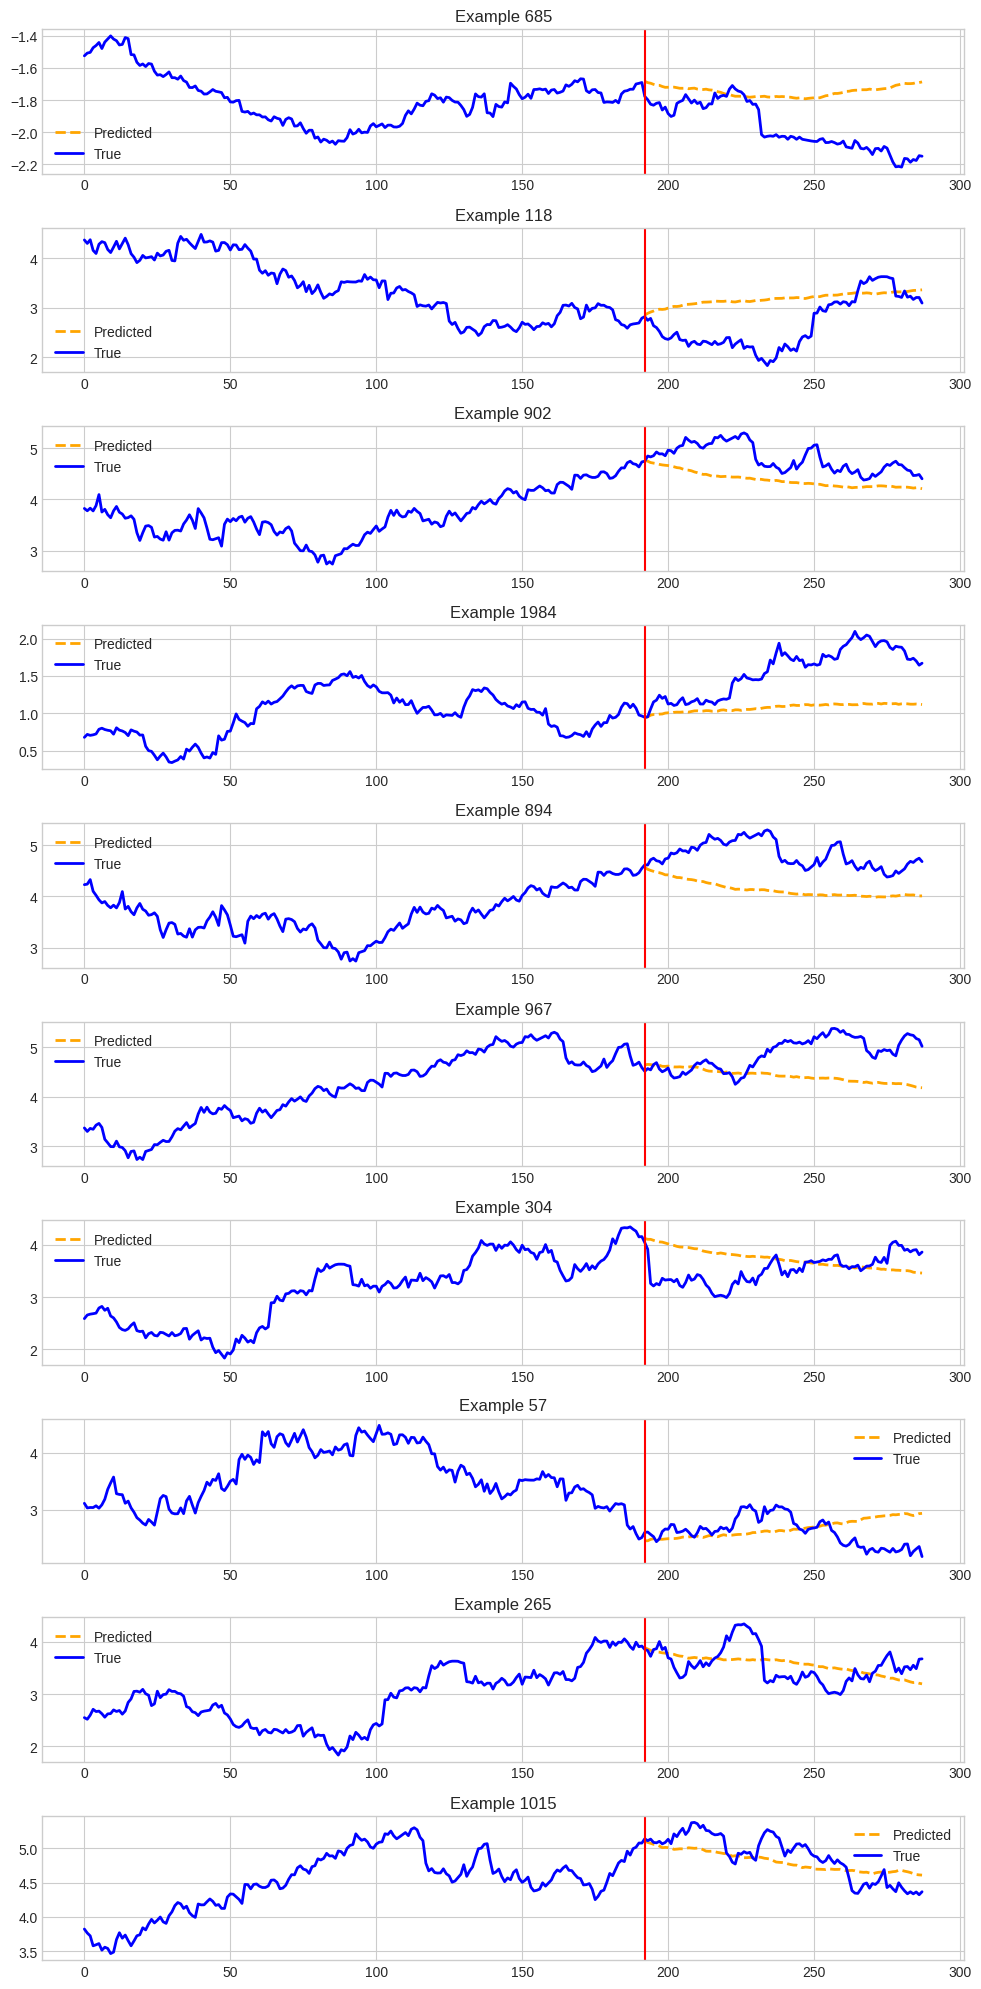

In [45]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [48]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.442100,0.775728
2,0.440500,0.775884
3,0.405500,0.776145
4,0.421700,0.776001
5,0.397500,0.775799
6,0.431200,0.775737
7,0.400600,0.775547
8,0.388100,0.775533
9,0.358600,0.776146
10,0.353500,0.776911


[TrackingCallback] Mean Epoch Time = 1.27321371767256 seconds, Total Train Time = 2303.38329577446
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.7691217660903931, 'eval_runtime': 123.5977, 'eval_samples_per_second': 75.705, 'eval_steps_per_second': 1.189, 'epoch': 18.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(9357, 96, 18)
(9357, 18, 8, 192)


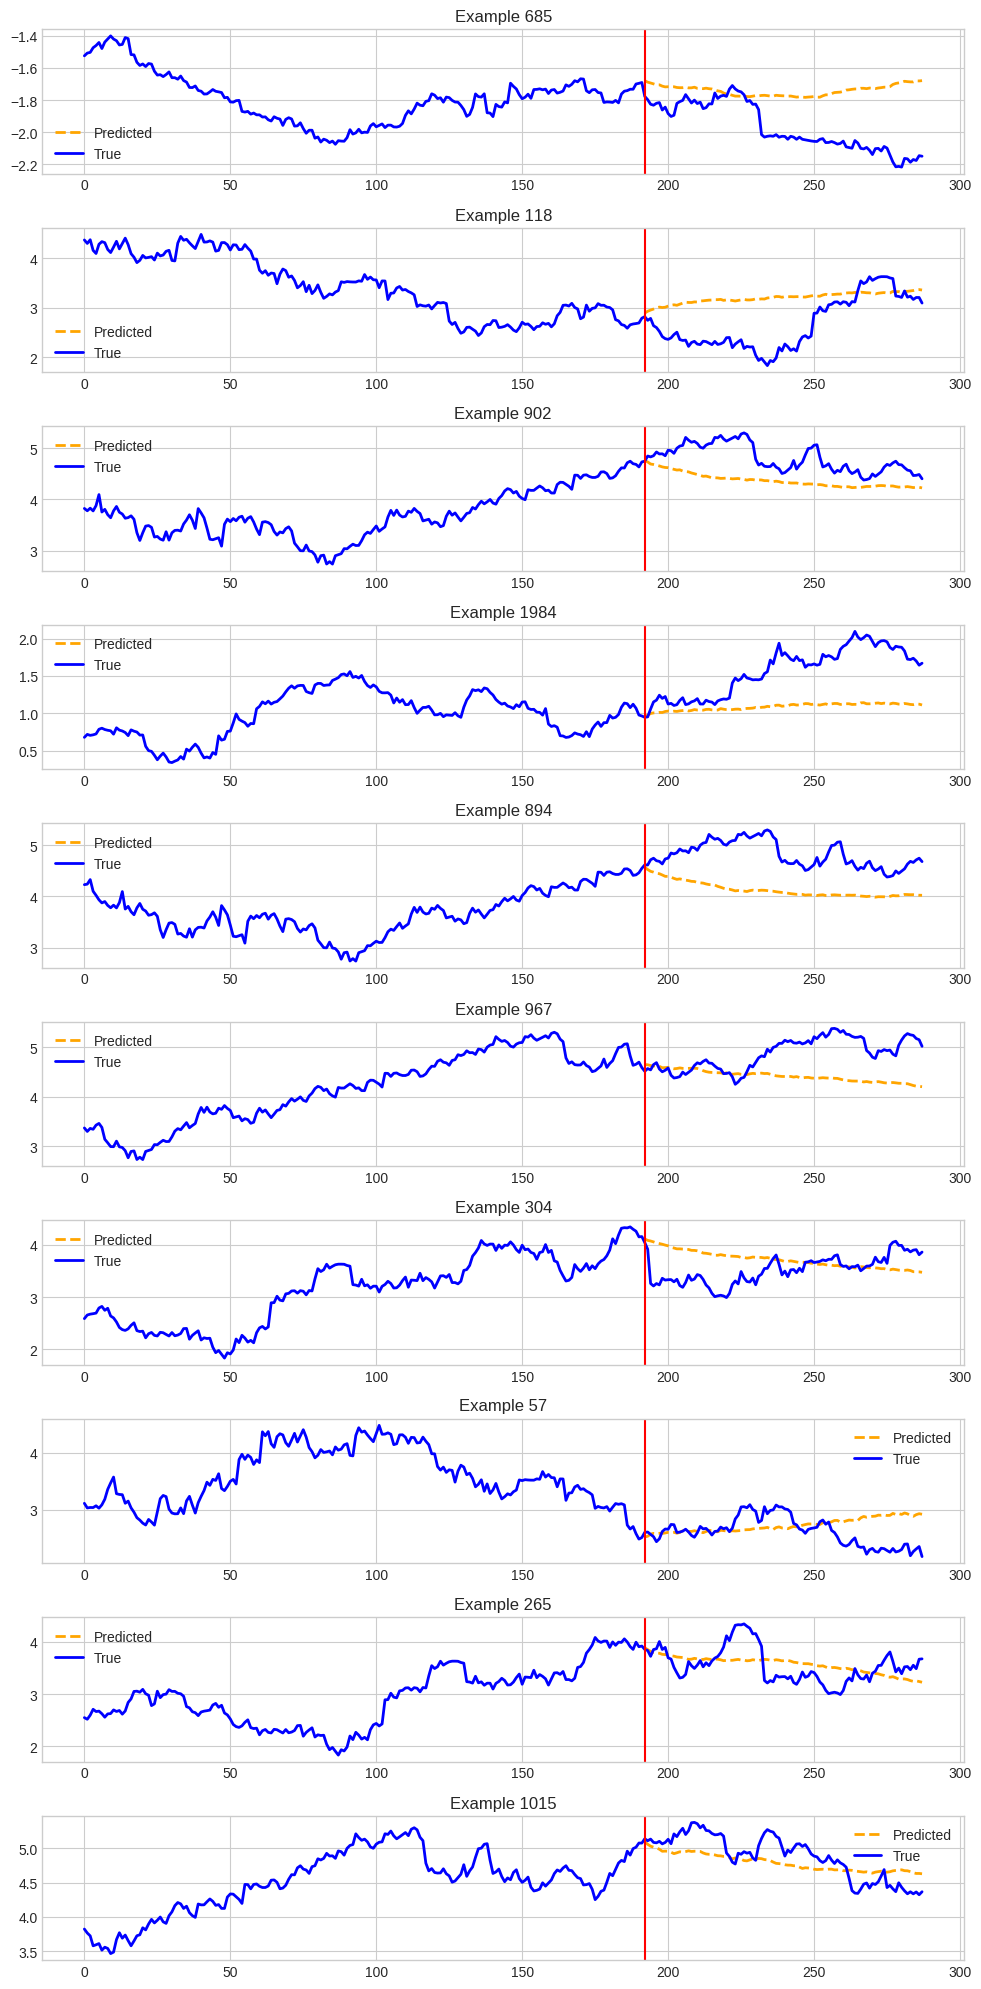

In [47]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.174600,0.266901
2,0.172200,0.267098
3,0.169900,0.267492
4,0.172300,0.268018
5,0.168000,0.268820
6,0.168300,0.270173
7,0.165200,0.271995
8,0.159500,0.274170
9,0.154900,0.276547
10,0.153700,0.279082


[TrackingCallback] Mean Epoch Time = 1.8255129293961958 seconds, Total Train Time = 1470.8042929172516
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.7718746662139893, 'eval_runtime': 125.832, 'eval_samples_per_second': 74.361, 'eval_steps_per_second': 1.168, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(9357, 96, 18)
(9357, 18, 8, 192)


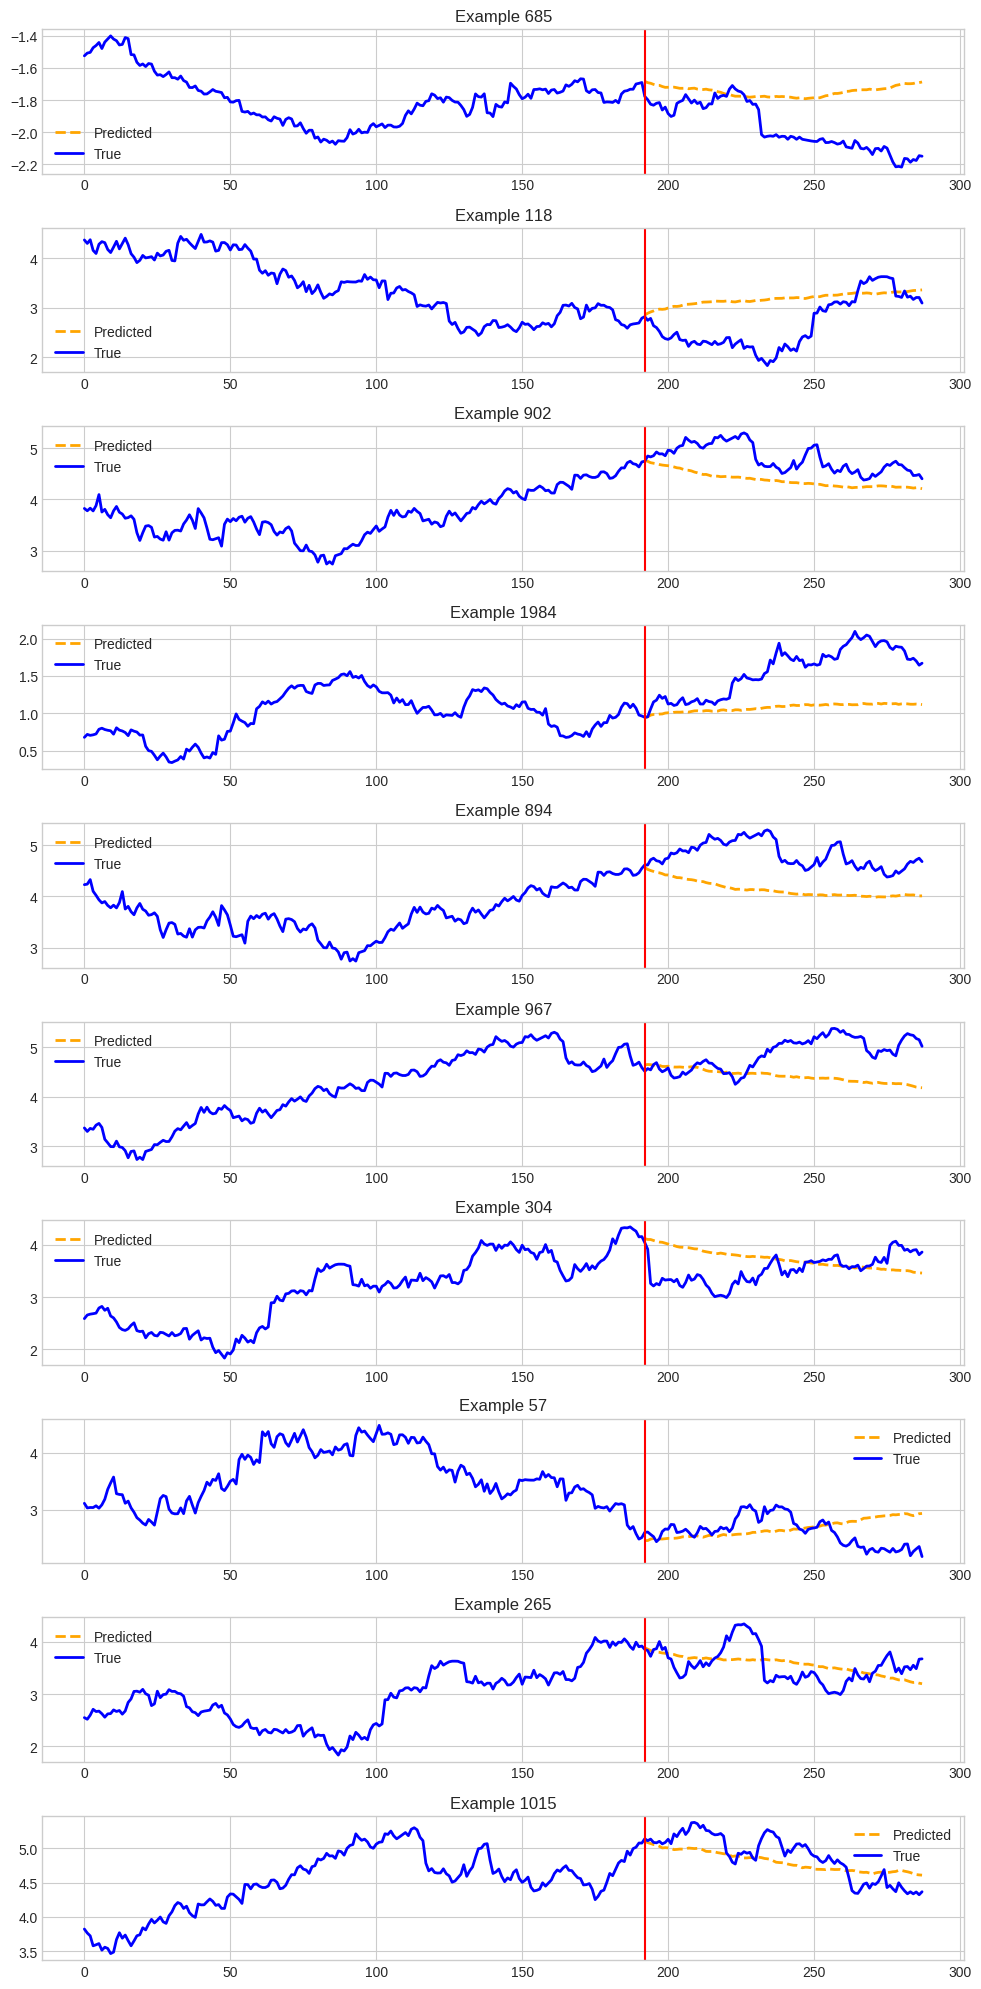

In [49]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards)

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

# Without Macro Variables

In [51]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "/content/Macro_with_stocks.csv"
timestamp_column = "DateOnly_x"
id_columns = ["Stock_encoded"]  # mention the ids that uniquely identify a time-series.

target_columns = ["Close"]
split_config = {
    "train": [0.0, 0.6],
    "valid": [0.6, 0.8],
    "test": [0.8, 1.0],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [ 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],
}

In [52]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

In [53]:
required_length = CONTEXT_LENGTH + PREDICTION_LENGTH
counts = df['Stock_encoded'].value_counts()
too_short = counts[counts < required_length]

print(f"Number of short series: {len(too_short)}")
print("Example of short series lengths:", too_short.head())

Number of short series: 0
Example of short series lengths: Series([], Name: count, dtype: int64)


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.951377809047699, 'eval_model_preparation_time': 0.0027, 'eval_runtime': 50.7738, 'eval_samples_per_second': 184.288, 'eval_steps_per_second': 2.895}
(9357, 96, 7)
(9357, 7, 8, 192)


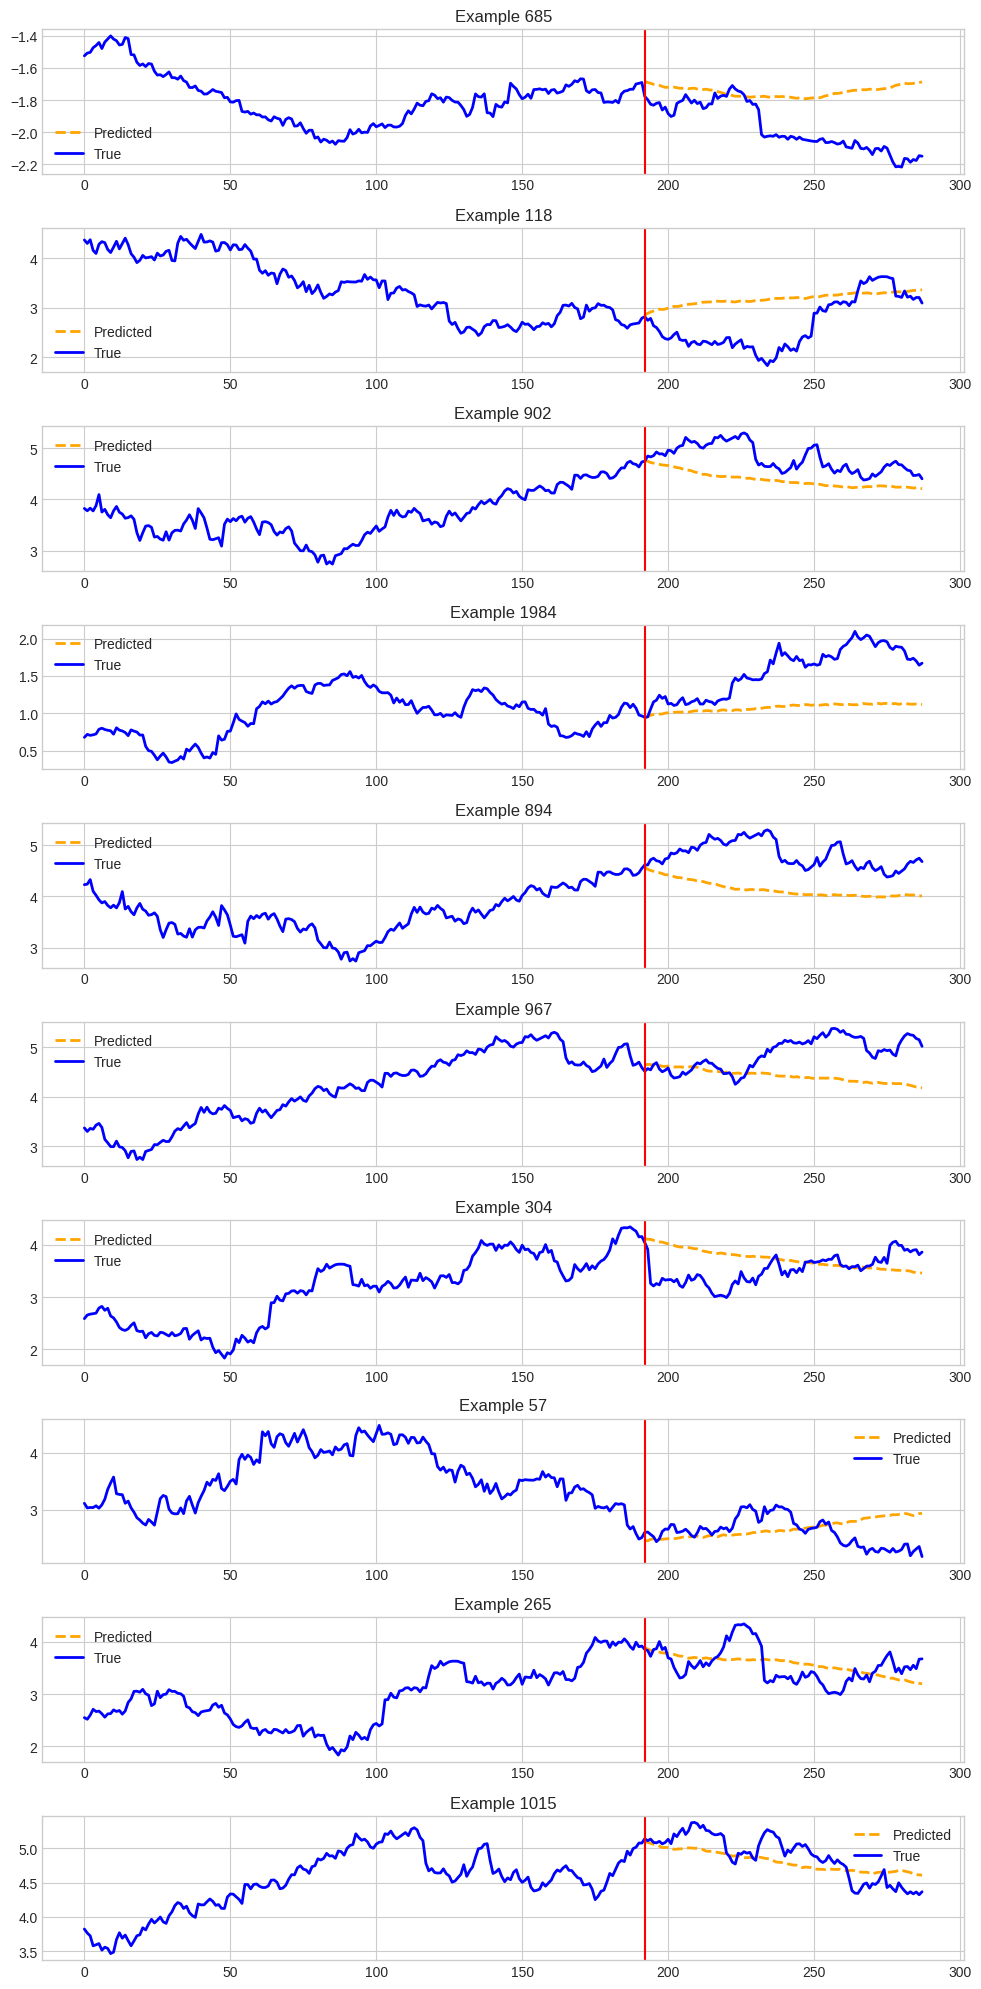

In [54]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

In [55]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.487300,0.776573
2,0.487300,0.776289
3,0.477600,0.776151
4,0.459000,0.776033
5,0.481600,0.775637
6,0.475300,0.774910
7,0.475000,0.773754
8,0.465300,0.772519
9,0.493600,0.771239
10,0.433600,0.768354


[TrackingCallback] Mean Epoch Time = 0.9670668840408325 seconds, Total Train Time = 1388.2062256336212
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.8968290090560913, 'eval_runtime': 52.2165, 'eval_samples_per_second': 179.196, 'eval_steps_per_second': 2.815, 'epoch': 26.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(9357, 96, 7)
(9357, 7, 8, 192)


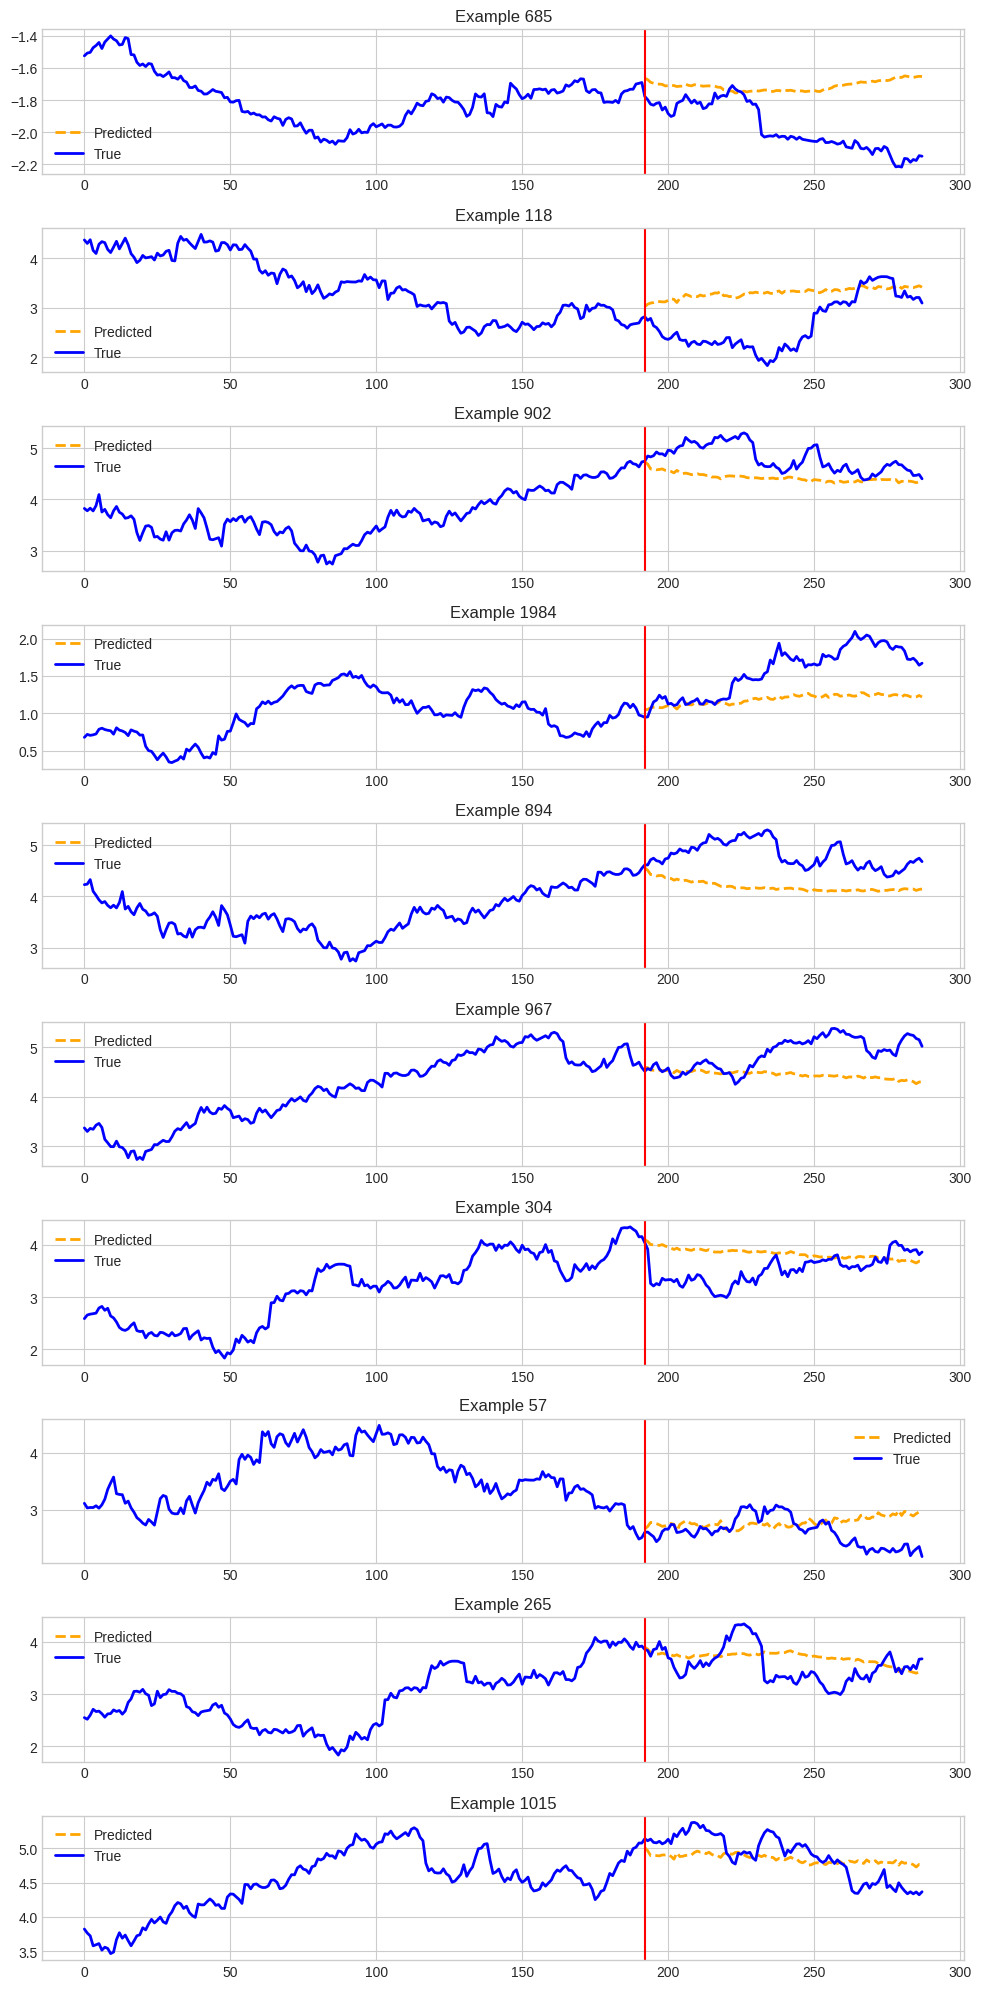

In [56]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.162800,0.230679
2,0.163300,0.230702
3,0.163800,0.230782
4,0.155100,0.230924
5,0.159400,0.231134
6,0.161200,0.231457
7,0.157900,0.231954
8,0.152100,0.232675
9,0.151100,0.233543
10,0.146500,0.234591


[TrackingCallback] Mean Epoch Time = 1.0167935328050093 seconds, Total Train Time = 588.4984428882599
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.9511727094650269, 'eval_runtime': 57.4605, 'eval_samples_per_second': 162.842, 'eval_steps_per_second': 2.558, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(9357, 96, 7)
(9357, 7, 8, 192)


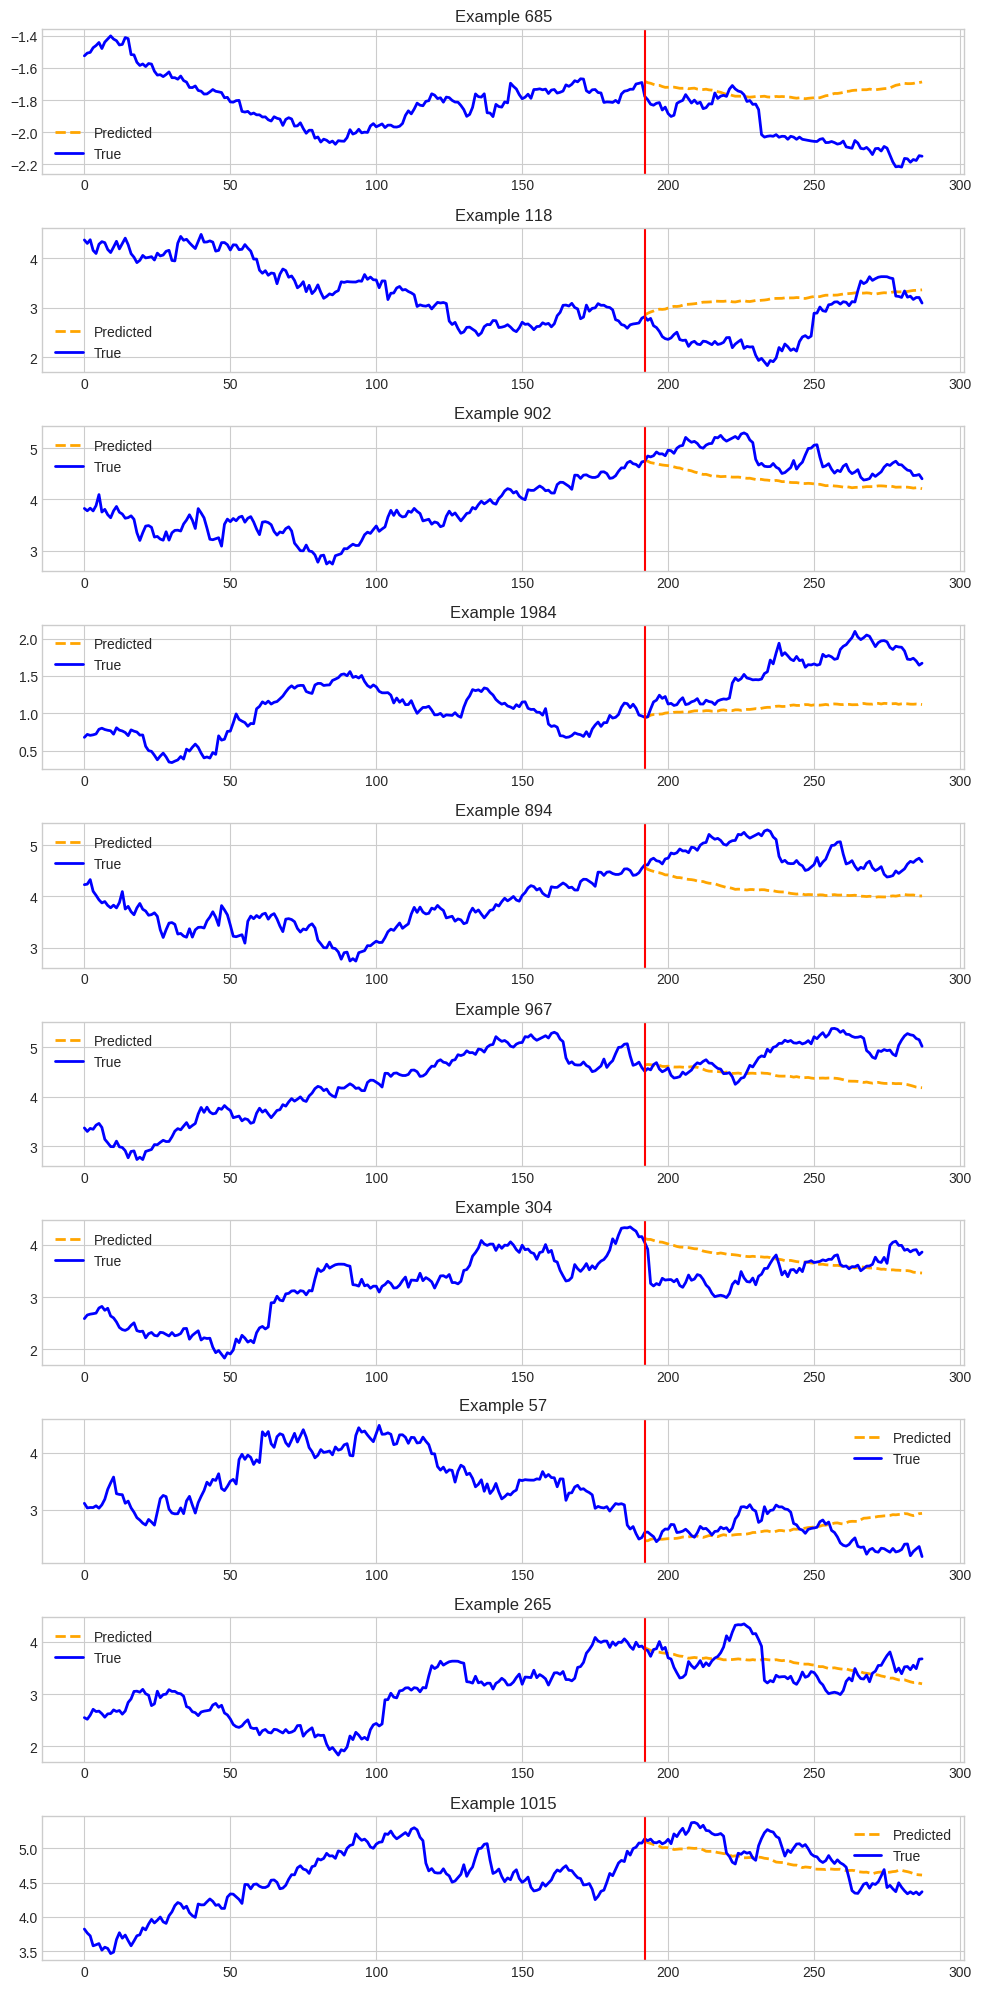

In [57]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)